---
date: last-modified
---

# ARSET Training (August 2025)

## D2P2: Downloading and interpreting TEMPO Data Files programmatically from NASA Earthdata.

**Demonstration for working with TEMPO data via `Harmony-py`**

## Overview

This hands-on tutorial demonstrates how to programmatically access and analyze TEMPO air quality data using Python to monitor air quality impacts from the Madre wildfire. You'll learn to efficiently download TEMPO NO₂ data using `harmony-py`, apply quality filtering, and create maps of air quality data showing wildfire emission patterns.

**Why programmatic access?** Automate data retrieval for regular monitoring workflows, batch processing, and reproducible analysis—building on the browser-based download methods you've already learned.

**Tutorial Navigation:** Variables and text highlighted in <mark>yellow</mark> are key parameters you'll likely want to modify for your own region, time period, or data requirements.

### Prerequisites

**Required:**
- Free [NASA Earthdata Login account](https://www.earthdata.nasa.gov/)
- Basic Python knowledge (variables, loops, functions)
- Familiarity with TEMPO instrument and data products (from previous ARSET presentations)

**Python Libraries:**
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - for map projections and geographic visualization
- [harmony-py](https://github.com/nasa/harmony-py) - for accessing NASA's Harmony data services
- [matplotlib](http://matplotlib.org/) - for creating plots and visualizations
- [numpy](https://numpy.org/) - for numerical operations
- [xarray](https://github.com/pydata/xarray) - for working with multi-dimensional scientific data


### Data & Scope

- **Product**: TEMPO_NO2_L3_V03 (Level-3 gridded NO₂ columns)
- **Resolution**: approximately 2.1 km × 4.4 km, hourly during daylight
- **Coverage**: North America
- **Example region**: <mark>Madre wildfire area, New Cuyama, California</mark>

*Methods apply to other TEMPO products (formaldehyde, ozone, etc.) and regions within North America.*

### Notebook Author / Affiliation
- Author: Daniel Kaufman / Atmospheric Science Data Center
- This notebook is based on examples from the [harmony-py repository](https://github.com/nasa/harmony-py/tree/main/examples) and [Harmony documentation](https://harmony.earthdata.nasa.gov/docs).

## 1. Setup

Install required packages (these may not be pre-installed in all environments)

In [1]:
!pip install --quiet harmony-py cartopy

Import Python libraries for data access, processing, and visualization

In [2]:
# For Section 2. Downloading TEMPO data
import datetime as dt
import getpass
import os
from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

# For Section 3. Opening TEMPO data files
import xarray as xr

# For Section 4. Creating graphics for a TEMPO data variable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

## 2. Downloading TEMPO data (via Harmony)

**Estimated time:** 2-5 minutes for this example (it will depend on data size and network speed)

### 2.1 Authentication with NASA Earthdata

Enter your Earthdata Login credentials (<mark>username</mark> and <mark>password</mark>) to access TEMPO data. Your credentials are securely passed to NASA's servers and are not stored in this notebook.

In [3]:
print("Please provide your Earthdata Login credentials to allow data access")
print("Your credentials will only be passed to Earthdata and will not be exposed in the notebook")
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


Username: dkaufas
 ········


### 2.2 Compiling a Request

**Finding Collection IDs:** Search for "TEMPO_NO2_L3" in [NASA Earthdata Search](https://search.earthdata.nasa.gov/search), select your desired version, and copy the collection ID from the URL.

**Building a Data Request:** Configure your data request by specifying the data collection (i.e., NO₂, CH₂O, O₃; Processing Level; and Version, via <mark>Collection</mark>), time period (via <mark>temporal</mark>), and geographic area of interest (via <mark>spatial</mark>). The example below requests data for a <mark>15-minute window</mark> over the central United States.

In [4]:
print(f"This tutorial will download data for: {dt.datetime(2025, 7, 3, 20, 0, 0)} UTC")
print("This corresponds to approximately 1:00 PM Pacific time during the Madre wildfire")

This tutorial will download data for: 2025-07-03 20:00:00 UTC
This corresponds to approximately 1:00 PM Pacific time during the Madre wildfire


In [5]:
print("Note: TEMPO times are in UTC. For western US:")
print("- PST = UTC - 8 hours")
print("- PDT = UTC - 7 hours")
print("- MST = UTC - 7 hours")
print("- MDT = UTC - 6 hours")

Note: TEMPO times are in UTC. For western US:
- PST = UTC - 8 hours
- PDT = UTC - 7 hours
- MST = UTC - 7 hours
- MDT = UTC - 6 hours


**Spatial Coverage:** The following example uses a rectangle that covers the <mark>Madre wildfire area near New Cuyama, California</mark>:
- Longitude: <mark>-121° to -119° (2° wide)</mark>
- Latitude: <mark>34° to 36° (2° tall)</mark>

[View the coverage area](https://geojson.io/#data=data:application/json,%7B%22type%22%3A%22FeatureCollection%22%2C%22features%22%3A%5B%7B%22type%22%3A%22Feature%22%2C%22geometry%22%3A%7B%22type%22%3A%22Polygon%22%2C%22coordinates%22%3A%5B%5B%5B-121%2C34%5D%2C%5B-121%2C36%5D%2C%5B-119%2C36%5D%2C%5B-119%2C34%5D%2C%5B-121%2C34%5D%5D%5D%7D%2C%22properties%22%3A%7B%7D%7D%5D%7D)

In [6]:
request = Request(
    # This ID is for the Level-2, V03, "Nitrogen Dioxide total column" collection:
    # collection=Collection(id="C2930725014-LARC_CLOUD"),
    # This ID is for the Level-3, V03, "Nitrogen Dioxide tropospheric and stratospheric columns" collection:
    collection=Collection(id="C2930763263-LARC_CLOUD"),
    # This is a 15 minute time period (reminder, it's in UTC time):
    temporal={
        "start": dt.datetime(2025, 7, 3, 20, 0, 0),  # Day after fire start
        "stop": dt.datetime(2025, 7, 3, 20, 15, 0),
    },
    # This is a rectangular area in California
    spatial=BBox(-121, 34, -119, 36),  # New Cuyama area
    # Note that there is not a particular granule specified!
    # However, one could be specified by passing a granule ID, e.g.:
    #
    # granule_name=["TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc"],
    #
)

In [7]:
# Validate the request before submitting
print("Request validation:")
print(f"✓ Valid request: {request.is_valid()}")
print(f"✓ Time period: {request.temporal['start']} to {request.temporal['stop']}")
print(f"✓ Spatial bounds: {request.spatial}")

Request validation:
✓ Valid request: True
✓ Time period: 2025-07-03 20:00:00 to 2025-07-03 20:15:00
✓ Spatial bounds: BBox: West:-121, South:34, East:-119, North:36


### 2.3 Submit and Monitor the Request

Submit your request to Harmony's processing queue. The job ID allows you to track processing status.

In [8]:
job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")

harmony_client.wait_for_processing(job_id, show_progress=True)

jobID = e3f43654-51e4-47f7-9e22-3e233d85816b


 [ Processing: 100% ] |###################################################| [|]


### 2.4 Download Processed Data

Download the subset data files to your local system. Files are saved to a `tempo_data` folder (<mark>download_dir</mark>) in your home directory.

In [9]:
download_dir = os.path.expanduser("~/tempo_data")
os.makedirs(download_dir, exist_ok=True)

In [10]:
results = harmony_client.download_all(job_id, directory=download_dir)
all_results_stored = [f.result() for f in results]

print("✓ Data downloaded successfully!")
print(f"✓ Files saved to: {download_dir}")
print(f"✓ Number of files: {len(all_results_stored)}")

/home/jovyan/tempo_data/106095248_TEMPO_NO2_L3_V03_20250703T190954Z_S011_subsetted.nc4
/home/jovyan/tempo_data/106095249_TEMPO_NO2_L3_V03_20250703T200954Z_S012_subsetted.nc4
✓ Data downloaded successfully!
✓ Files saved to: /home/jovyan/tempo_data
✓ Number of files: 2


### 2.5 Troubleshooting Common Issues

**Authentication errors:** Verify your Earthdata Login credentials are correct

**No data returned:** 
- Check that your time period is after August 2023 (TEMPO operational start)
- Verify your spatial bounds overlap with the TEMPO Field of Regard in North America
- Try a broader time window (TEMPO has hourly coverage during daylight)

**Large downloads:** Start with smaller spatial areas or shorter time periods for testing

**Memory issues:** Close other applications or process files individually rather than loading multiple simultaneously

## 3. Opening TEMPO data files

### Alternative Entry Point

**If you already have TEMPO data files** (downloaded via Earthdata Search or other methods), you can start here by pointing to your file location.

**To use your own data:** Replace the <mark>file_path</mark> below with your data file location:

In [11]:
file_path = all_results_stored[0]

In the following cell, we open the file, and can inspect the preview of data file groups, dimensions, time and space coordinates, data variables, and other attributes.

In [12]:
datatree = xr.open_datatree(file_path)
datatree

<xarray.DataTree>
Group: /
│   Dimensions:    (longitude: 100, latitude: 100, time: 1)
│   Coordinates:
│     * longitude  (longitude) float32 400B -121.0 -121.0 -120.9 ... -119.0 -119.0
│     * latitude   (latitude) float32 400B 34.01 34.03 34.05 ... 35.95 35.97 35.99
│     * time       (time) datetime64[ns] 8B 2025-07-03T19:10:12.023863552
│   Data variables:
│       weight     (latitude, longitude) float32 40kB ...
│   Attributes: (12/47)
│       history:                             2025-07-04T00:39:45Z: L2_regrid -v /...
│       scan_num:                            11
│       time_coverage_start:                 2025-07-03T19:09:54Z
│       time_coverage_end:                   2025-07-03T20:09:35Z
│       time_coverage_start_since_epoch:     1435605012.0238636
│       time_coverage_end_since_epoch:       1435608593.6442022
│       ...                                  ...
│       build_dmrpp_metadata.build_dmrpp:    3.21.0-526
│       build_dmrpp_metadata.bes:            3.21.0-526
│       build_dmrpp_metadata.libdap:         libdap-3.21.0-120
│       build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
│       build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_aR2U -f...
│       history_json:                        [{"$schema":"https:\/\/harmony.earth...
├── Group: /product
│       Dimensions:                                  (time: 1, latitude: 100,
│                                                     longitude: 100)
│       Data variables:
│           vertical_column_troposphere              (time, latitude, longitude) float64 80kB ...
│           vertical_column_troposphere_uncertainty  (time, latitude, longitude) float64 80kB ...
│           vertical_column_stratosphere             (time, latitude, longitude) float64 80kB ...
│           main_data_quality_flag                   (time, latitude, longitude) float32 40kB ...
├── Group: /qa_statistics
│       Dimensions:                                              (time: 1,
│                                                                 latitude: 100,
│                                                                 longitude: 100)
│       Data variables:
│           num_vertical_column_total_samples                    (time, latitude, longitude) float64 80kB ...
│           max_vertical_column_troposphere_sample               (time, latitude, longitude) float64 80kB ...
│           min_vertical_column_stratosphere_sample              (time, latitude, longitude) float64 80kB ...
│           num_vertical_column_stratosphere_samples             (time, latitude, longitude) float64 80kB ...
│           num_vertical_column_troposphere_samples              (time, latitude, longitude) float64 80kB ...
│           min_vertical_column_total_sample                     (time, latitude, longitude) float64 80kB ...
│           num_vertical_column_troposphere_uncertainty_samples  (time, latitude, longitude) float64 80kB ...
│           max_vertical_column_troposphere_uncertainty_sample   (time, latitude, longitude) float64 80kB ...
│           min_vertical_column_troposphere_uncertainty_sample   (time, latitude, longitude) float64 80kB ...
│           max_vertical_column_total_sample                     (time, latitude, longitude) float64 80kB ...
│           max_vertical_column_stratosphere_sample              (time, latitude, longitude) float64 80kB ...
│           min_vertical_column_troposphere_sample               (time, latitude, longitude) float64 80kB ...
├── Group: /support_data
│       Dimensions:                            (time: 1, latitude: 100, longitude: 100)
│       Data variables: (12/15)
│           surface_pressure                   (time, latitude, longitude) float32 40kB ...
│           amf_cloud_pressure                 (time, latitude, longitude) float32 40kB ...
│           vertical_column_total_uncertainty  (time, latitude, longitude) float64 80kB ...
│           vertical_column_total              (time, latitude, longi

## 4. Creating graphics for a TEMPO data variable

### Visualizing NO₂ Data

Let's examine the **tropospheric NO₂ column** data (specified by <mark>vertical_column_troposphere</mark>, which is in the "product" group) - this represents the total amount of NO₂ in the lower atmosphere, which is most relevant for air quality applications.

In [13]:
product_variable_name = "product/vertical_column_troposphere"
data_array = datatree[product_variable_name]
data_array

<xarray.DataArray 'vertical_column_troposphere' (time: 1, latitude: 100,
                                                 longitude: 100)> Size: 80kB
[10000 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 400B -121.0 -121.0 -120.9 ... -119.0 -119.0
  * latitude   (latitude) float32 400B 34.01 34.03 34.05 ... 35.95 35.97 35.99
  * time       (time) datetime64[ns] 8B 2025-07-03T19:10:12.023863552
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

### 4.1 Apply Quality Control

TEMPO provides quality flags to help identify reliable measurements:
- `0` = Normal quality (use for analysis)
- `1` = Suspect quality (use with caution)
- `2` = Bad quality (exclude from analysis)

We'll filter to show only high-quality data.

In [14]:
good_array = data_array.where(datatree["product/main_data_quality_flag"] == 0).squeeze()
good_array

<xarray.DataArray 'vertical_column_troposphere' (latitude: 100, longitude: 100)> Size: 80kB
array([[ 1.17985543e+14,  6.88726426e+13,  4.87971411e+13, ...,
         1.99839833e+15,  1.57523620e+15,  1.57592455e+15],
       [-9.98911362e+13, -9.89862570e+13, -5.57711709e+13, ...,
         2.15819213e+15,  1.95313842e+15,  1.97430521e+15],
       [ 7.64580802e+12,  1.51477907e+13,  8.55862810e+12, ...,
         3.08531262e+15,  3.14636714e+15,  3.20648988e+15],
       ...,
       [ 1.81857543e+14,  2.16539103e+14,  2.56319977e+14, ...,
         3.24688498e+14,  3.78641235e+14,  6.18058589e+14],
       [ 9.57753225e+14,  9.39091146e+14,  8.60047819e+14, ...,
         1.49036916e+15,  1.50893256e+15, -2.40818117e+14],
       [ 3.94494713e+14,  4.65439421e+14,  6.19059000e+14, ...,
         2.69994390e+15,  1.95738718e+15,  7.36510846e+14]],
      shape=(100, 100))
Coordinates:
  * longitude  (longitude) float32 400B -121.0 -121.0 -120.9 ... -119.0 -119.0
  * latitude   (latitude) float32 400B 34.01 34.03 34.05 ... 35.95 35.97 35.99
    time       datetime64[ns] 8B 2025-07-03T19:10:12.023863552
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

In [15]:
print(f"Data size in memory: {good_array.nbytes / 1e6:.1f} MB")

Data size in memory: 0.1 MB


In [16]:
# Let's do a general look at the values.
print(
    f"Data range: {good_array.min().values:.2e} to {good_array.max().values:.2e} {data_array.attrs.get('units', '')}"
)
print(f"Mean value: {good_array.mean().values:.2e}")
print("\nFor reference:")
print("- Typical urban NO₂ tropospheric columns: 1-5×10¹⁵ molecules/cm²")
print("- Clean rural areas: <1×10¹⁵ molecules/cm²")
print("- Wildfire-affected areas: May show elevated NO₂ from combustion processes")

Data range: -3.80e+15 to 3.49e+16 molecules/cm^2
Mean value: 1.61e+15

For reference:
- Typical urban NO₂ tropospheric columns: 1-5×10¹⁵ molecules/cm²
- Clean rural areas: <1×10¹⁵ molecules/cm²
- Wildfire-affected areas: May show elevated NO₂ from combustion processes


### 4.2 Create a Good-looking Map

Generate a publication-ready map showing NO₂ concentrations with state boundaries and coordinate labels, within a broader regional <mark>extent</mark>.

In [17]:
data_proj = ccrs.PlateCarree()

roads = cfeature.NaturalEarthFeature(
    category="cultural",
    name="roads",
    scale="10m",  # The dataset scale (e.g., '10m', '50m', '110m')
    facecolor="grey",
)

## If you wanted to add County boundaries, you could un-comment the following lines
##    and the axis.add_feature() call below
# admin_2_counties = cfeature.NaturalEarthFeature(
#     category='cultural',
#     name='admin_2_counties',
#     scale='10m',  # The dataset scale (e.g., '10m', '50m', '110m')
#     facecolor='none'
# )


def make_nice_map(axis):
    axis.set_extent([-122, -118, 33.5, 36.5], crs=data_proj)  # Central California

    axis.add_feature(cfeature.OCEAN, color="lightblue")
    axis.add_feature(cfeature.STATES, color="grey", linewidth=1)
    axis.add_feature(roads, linestyle="-", edgecolor="white", linewidth=0.8)
    # axis.add_feature(admin_2_counties, edgecolor='white', linewidth=0.3)

    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True, linestyle=":")
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

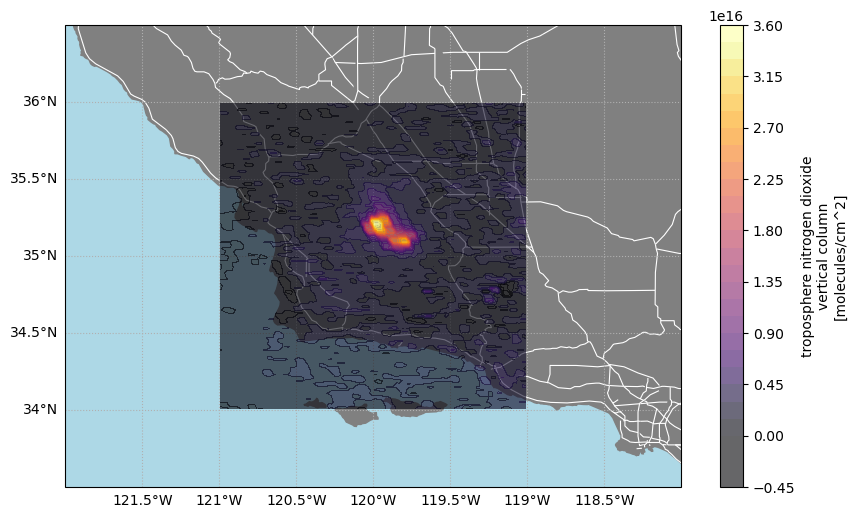

In [18]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

make_nice_map(ax)

contour_handle = ax.contourf(
    datatree["geolocation/longitude"],
    datatree["geolocation/latitude"],
    good_array,
    levels=30,
    vmin=0,
    vmax=float(good_array.max()),
    alpha=0.6,
    cmap="inferno",
    zorder=2,
)

cb = plt.colorbar(contour_handle)
cb.set_label(label_from_attrs(data_array))

plt.show()

In [19]:
print("✓ Map created successfully!")
print("✓ Tutorial complete - you've successfully accessed and visualized TEMPO data!")

✓ Map created successfully!
✓ Tutorial complete - you've successfully accessed and visualized TEMPO data!


## Tutorial Complete

**What you accomplished:**
- ✅ Set up programmatic access to NASA TEMPO data
- ✅ Downloaded and subset TEMPO NO₂ data for a specific region and time
- ✅ Applied quality filtering to ensure reliable measurements  
- ✅ Created a professional map visualization of air quality data

**Key skills gained:**
- Using harmony-py for NASA data access
- Working with TEMPO data structure and quality flags
- Creating publication-ready maps with cartopy and matplotlib

You now have the foundation to adapt this workflow for your own air quality monitoring needs!

## Potential Next Steps for Air Quality Analyses

This tutorial covered basic TEMPO data access via Harmony. Consider these extensions:

**Analysis Expansions:**
- Time series analysis across multiple periods
- Integration with ground monitoring stations
- Statistical trend analysis and anomaly detection

**Alternative Access Methods:**
- **`earthaccess` package** - Simplified NASA data access
- **VirtualiZarr** - Cloud-native analysis without downloads
- **Direct cloud access** - AWS S3 integration for large-scale processing

**Operational Applications:**
- Multi-pollutant analysis (NO₂ + formaldehyde + ozone)
- Automated monitoring workflows
- Cross-platform validation studies

*While we won't have time to cover most of these topics in detail, we may be able to incorporate some into Day 3 activities or discuss them further after the training sessions.*